<a href="https://colab.research.google.com/github/Abhinavk910/Classification/blob/master/HR_Analytic/HR_Analytic_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()
! pip install -q kaggle
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [0]:
! kaggle datasets download -d rednivrug/wns-inno

  0% 0.00/971k [00:00<?, ?B/s]
100% 971k/971k [00:00<00:00, 62.5MB/s]


In [0]:
! unzip -q "wns-inno.zip"

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from xgboost import XGBClassifier

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import os
print(os.listdir())

['.config', 'kaggle.json', 'wns-inno.zip', 'sample_submission_M0L0uXE.csv', 'test_2umaH9m.csv', 'train_LZdllcl.csv', 'sample_data']


In [0]:
df = pd.read_csv("train_LZdllcl.csv", index_col=0)
print(df.shape)
df.head(2)

(54808, 13)


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
employee_id,,,,,,,,,,,,,
65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0


In [0]:
dftest = pd.read_csv("test_2umaH9m.csv", index_col=0)
# dftest['is_promoted'] = 3
print(dftest.shape)
dftest.head(2)


(23490, 12)


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
employee_id,,,,,,,,,,,,
8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51


In [0]:
promoted = df.is_promoted.value_counts()
percentage = df.is_promoted.value_counts()/df.is_promoted.value_counts().sum()*100
pd.DataFrame([promoted.values, percentage.values], columns=['Promoted', 'percentage'])

,Promoted,percentage
0,50140.000000,4668.000000
1,91.482995,8.517005


In [0]:
print('In df, Nan are \n', df.isna().sum()[df.isna().sum() != 0], '\n')
print('in dftest, Nan are \n', dftest.isna().sum()[dftest.isna().sum() != 0])

In df, Nan are 
 education               2409
previous_year_rating    4124
dtype: int64 

in dftest, Nan are 
 education               1034
previous_year_rating    1812
dtype: int64


In [0]:
dfmerged = pd.concat([df, dftest], axis = 0, sort = False)
dfmerged.shape

(78298, 13)

In [0]:
dfmerged.isna().sum()[dfmerged.isna().sum() != 0]

education                3443
previous_year_rating     5936
is_promoted             23490
dtype: int64

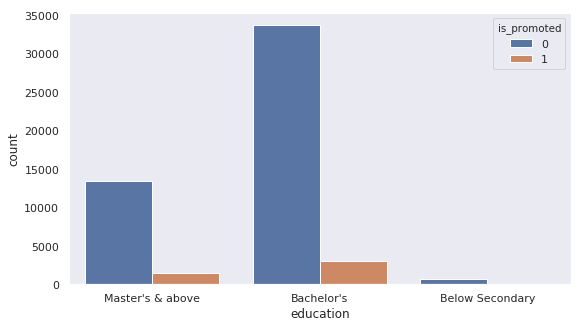

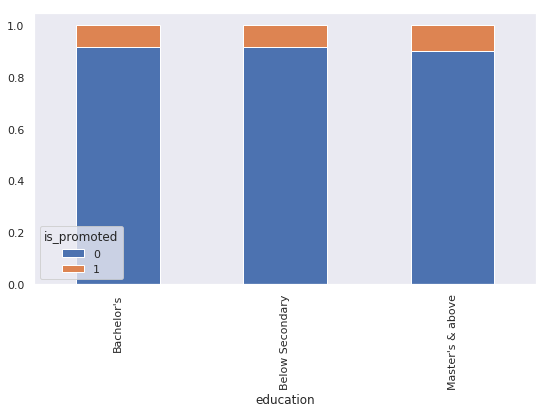

In [0]:
plt.figure(figsize = (9,5))

sns.countplot(x = 'education',hue = 'is_promoted', data = df)

pd.crosstab(df.education,df.is_promoted,normalize='index').plot(kind='bar', stacked = True, figsize = (9,5))

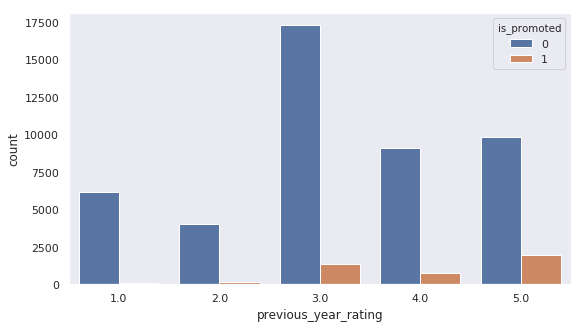

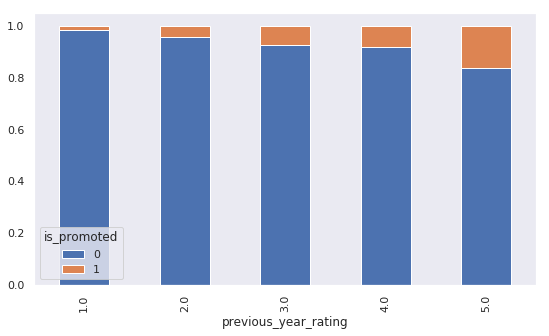

In [0]:
plt.figure(figsize = (9,5))
sns.countplot(x = 'previous_year_rating',hue = 'is_promoted', data = df)

pd.crosstab(df.previous_year_rating,df.is_promoted,normalize='index').plot(kind='bar', stacked = True, figsize = (9,5))

In [0]:
dfmerged.fillna({'previous_year_rating':dfmerged.previous_year_rating.mode().loc[0],
                  'education' : 'Bachelor\'s'}, inplace=True)

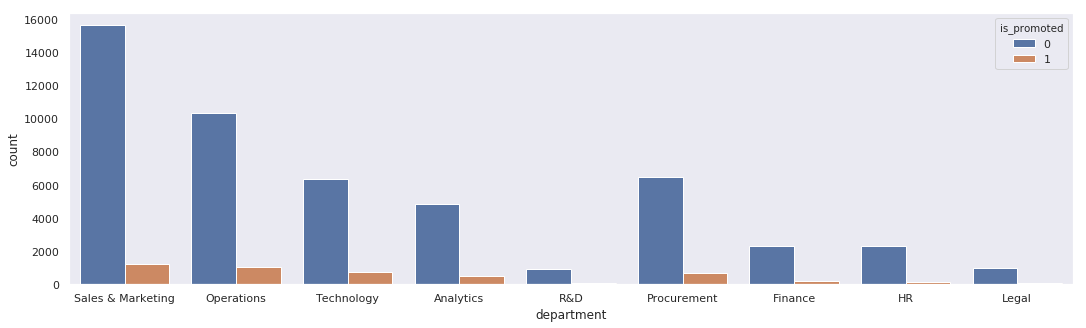

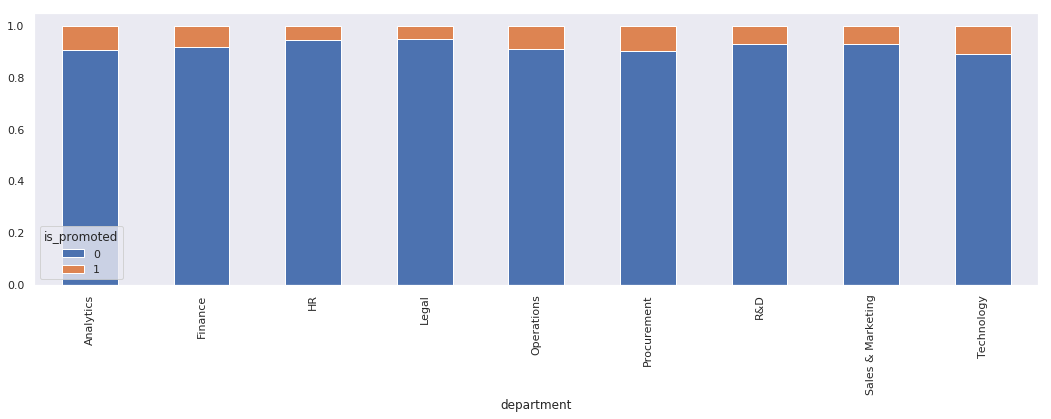

In [0]:
sns.set(style = 'dark')
plt.figure(figsize = (18,5))
sns.countplot(x = 'department',hue = 'is_promoted', data = df)
pd.crosstab(df.department,df.is_promoted,normalize='index').plot(kind = 'bar', stacked = True, figsize = (18,5))

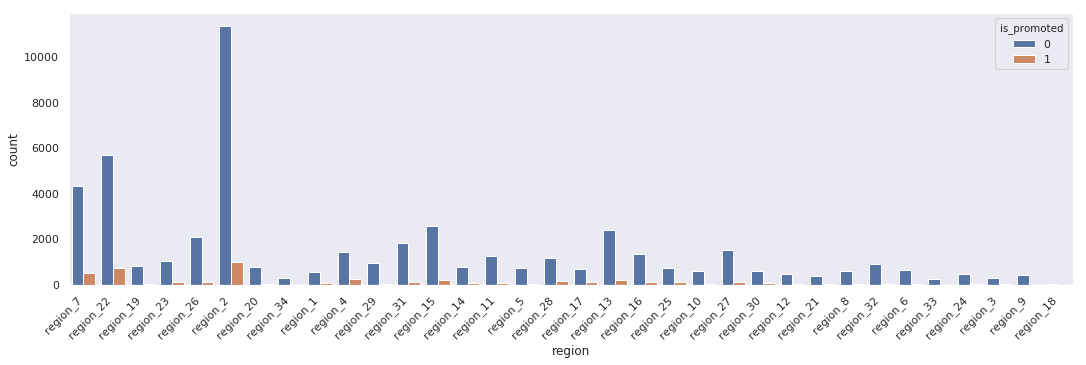

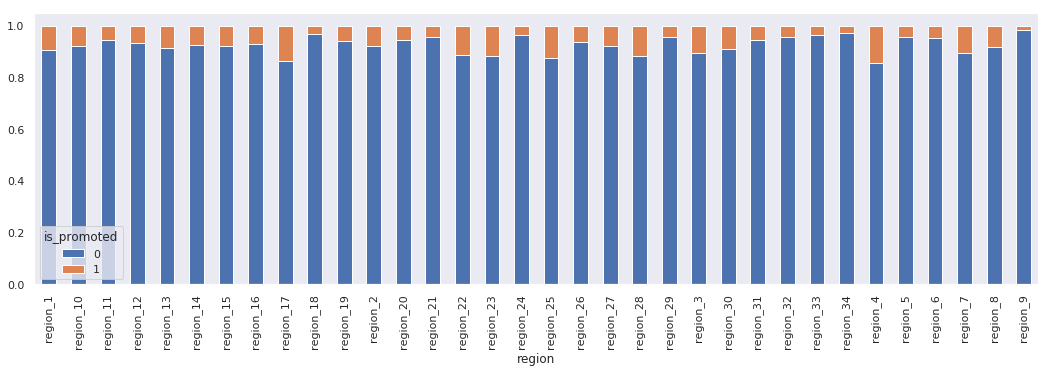

In [0]:
plt.figure(figsize = (18,5))
ax = sns.countplot(x = 'region',hue = 'is_promoted', data = df)
plt.xticks(rotation=45, ha='right')
pd.crosstab(df.region,df.is_promoted,normalize='index').plot(kind='bar', stacked = True, figsize = (18,5))

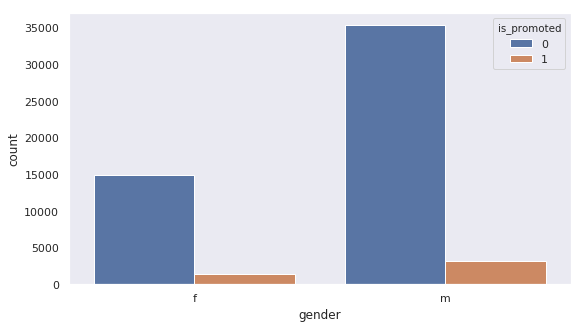

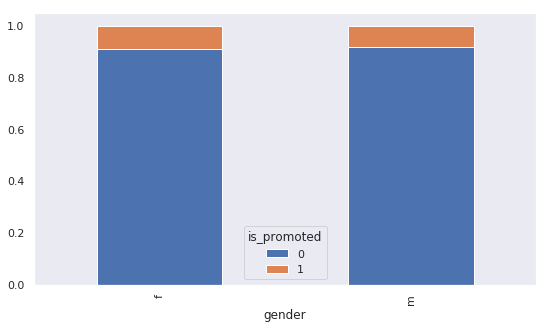

In [0]:
plt.figure(figsize = (9,5))
ax = sns.countplot(x = 'gender',hue = 'is_promoted', data = df)
pd.crosstab(df.gender,df.is_promoted,normalize='index').plot(kind='bar', stacked = True, figsize = (9,5))

In [0]:
bins = [30,50,70,90,100]
labels = ['30-50','50-70','70-90','90-100']
df['score_bin'] = pd.cut(df['avg_training_score'], bins=bins, labels=labels)
df['score_bin'].value_counts()

50-70     25993
70-90     16233
30-50     12003
90-100      579
Name: score_bin, dtype: int64

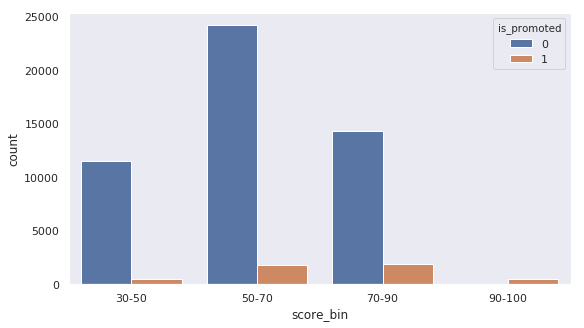

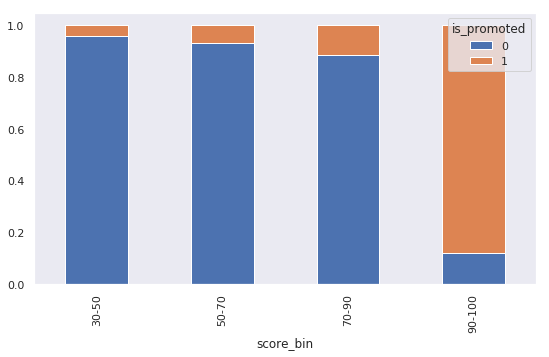

In [0]:
plt.figure(figsize = (9,5))
ax = sns.countplot(x = 'score_bin',hue = 'is_promoted', data = df)
pd.crosstab(df.score_bin,df.is_promoted,normalize='index').plot(kind='bar', stacked = True, figsize = (9,5))

In [0]:
age_bins = [20,30,40,50,60]
age_labels = ['20-30','30-40','40-50','50-60']
df['age_binned'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)
df.age_binned.value_counts()

30-40    26028
20-30    18005
40-50     7810
50-60     2852
Name: age_binned, dtype: int64

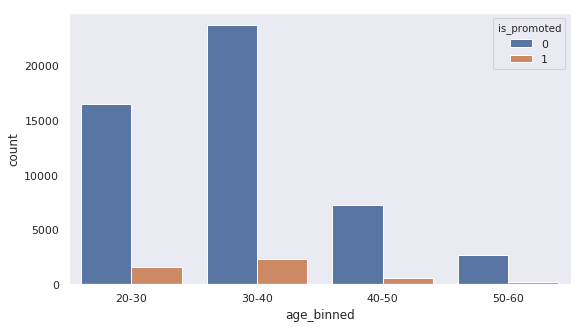

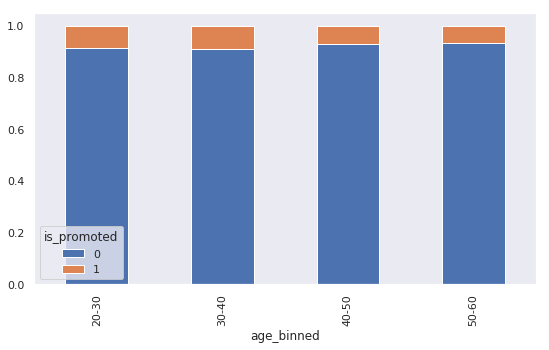

In [0]:
plt.figure(figsize = (9,5))
ax = sns.countplot(x = 'age_binned',hue = 'is_promoted', data = df)
pd.crosstab(df.age_binned,df.is_promoted,normalize='index').plot(kind='bar', stacked = True, figsize = (9,5))

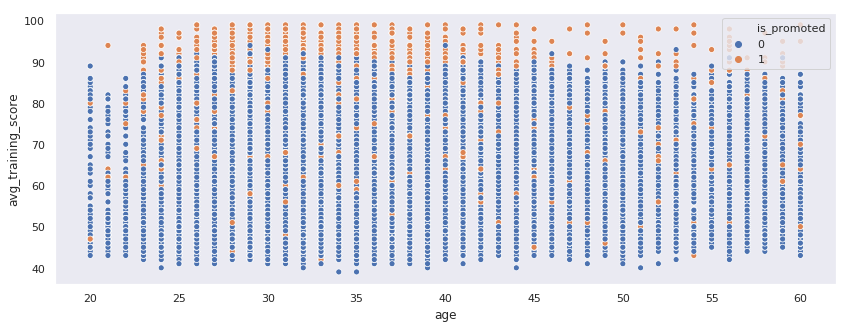

In [0]:
plt.figure(figsize = (14, 5))
sns.scatterplot(x='age',y='avg_training_score',hue='is_promoted',data=df)

In [0]:
dfmerged = pd.concat([dfmerged[['no_of_trainings','age','previous_year_rating','length_of_service','KPIs_met >80%',
                                'awards_won?','avg_training_score']],
                      pd.get_dummies(dfmerged['department'],drop_first = True),
                      pd.get_dummies(dfmerged['region'],drop_first = True),
                      pd.get_dummies(dfmerged['education'],drop_first = True),
                      pd.get_dummies(dfmerged['gender'],drop_first = True),
                      pd.get_dummies(dfmerged['recruitment_channel'],drop_first = True)],axis=1)
dfmerged.shape

In [0]:
X_totest = dfmerged[54808:]
X = dfmerged[:54808]

In [0]:
y = df.is_promoted

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
# param_grid = dict(n_estimators=np.arange(50,500,5),
#                   max_depth=np.arange(6,12),
#                   learning_rate=(0.0001,0.001,0.01,0.1))

# xgclass = GridSearchCV(XGBClassifier(random_state=0),
#                        param_grid=param_grid,
#                        scoring="precision")

xgclass = xgb.XGBClassifier(max_depth=9, n_estimators=450, learning_rate=0.01)
xgclass.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [0]:
y_pred = xgclass.fit(X_test)

In [0]:
# Checking roc_auc score

print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n Accuracy_score: %.2f%% on test dataset" % (accuracy * 100.0))
print("precision_score: %.2f%% on test dataset" % (precision * 100.0))
print("recall_score: %.2f%% on test dataset" % (recall * 100.0))
print("f1_score: %.2f%% on test dataset \n" % (f1 * 100.0))

print("roc_auc test set", roc_auc_score(y_test, gsearch2b3.predict_proba(X_test)[:,1]))
print("roc_auc training set", roc_auc_score(y_train, gsearch2b3.predict_proba(X_train)[:,1]))

[[10028    31]
 [  644   259]]

 Accuracy_score: 93.84% on test dataset
precision_score: 89.31% on test dataset
recall_score: 28.68% on test dataset
f1_score: 43.42% on test dataset 

roc_auc test set 0.8827375296382572
roc_auc training set 0.895636468952496


In [0]:
#predicting of test dataset
X_totest = X_totest.drop(['is_promoted'],1)

y_totest_pred = gsearch2b3.predict(X_totest)

In [0]:
#preparing solution format

submission = X_totest.copy()
submission['is_promoted'] = y_totest_pred
submission.reset_index(inplace=True)

In [0]:
# Writing on solution.csv file

submission = submission[['employee_id', 'is_promoted']]
submission.to_csv("solution.csv",index=False)